In [2]:
# Modify the test_model_width function to control width using m_z
from sympy import symbols, solve, Eq
import random
import os
import numpy as np
import torch
import torch.nn as nn



In [3]:
class MultiStepDNN(nn.Module):
    def __init__(self, m_x, m_z, m_o, n_layers, tau, p, alpha, beta, mode='given'):
        super(MultiStepDNN, self).__init__()
        # self.f = nn.ModuleList([
        #     nn.Sequential(
        #         nn.Linear(m_x, m_x*2),
        #         nn.ReLU(),
        #         nn.Linear(m_x*2, int(m_x/2)),
        #         nn.ReLU(),
        #         nn.Linear(int(m_x/2), m_x),
        #         nn.ReLU(),
        #         #nn.BatchNorm1d(m_x)
        #     ) for _ in range(n_layers)
        # ])
        self.f = nn.ModuleList([
            nn.Sequential(
            # nn.ReLU(),
            nn.Linear(m_x, m_x),
            nn.ReLU(),
            nn.Linear(m_x, m_x),
            nn.ReLU(),
            # nn.Linear(m_x, m_x),       
            # nn.ReLU(),
            # nn.Linear(m_x, m_x),      
            # nn.ReLU(),
            # nn.Linear(m_x, m_x),
            # nn.ReLU(),
            # nn.Linear(m_x, m_x),
            # nn.ReLU(),
            # nn.Linear(m_x, m_x),       
            # nn.ReLU(),
            # nn.Linear(m_x, m_x),                              
        )  for _ in range(n_layers)
        ])         
        self.zeta = nn.Linear(m_z, m_x)
        self.chi = nn.Linear(m_x, m_o)
        self.n_layers = n_layers
        self.tau = tau
        self.p = p
        self.k = p
        self.mode = mode
        # self.alpha = calculate_coefficients(p,p)
        # self.alpha = transform_output_to_list_of_lists(self.alpha)

        # self.alpha = [1, -1.5, 1.0, -0.5]
        # # self.alpha = [1, 0, 0, 0]
        # self.beta = [0, 1, 0, 0]
        self.alpha = alpha
        self.beta = beta          
            
        trainA, trainB = False, False
        self.D_alpha = nn.Parameter(torch.zeros_like(torch.tensor(self.alpha)), requires_grad=trainA)#True))#[1, -1.0/3, -5.0/9, -1.0/9]         
        self.D_beta = nn.Parameter(torch.zeros_like(torch.tensor(self.beta)), requires_grad=trainB)#True))#[0, -16.0/9, 0, 0]  
                
        if 'given' in mode:  
            self.alpha = nn.Parameter(torch.tensor(self.alpha), requires_grad=trainA)#True))#[1, -1.0/3, -5.0/9, -1.0/9] 
            self.beta = nn.Parameter(torch.tensor(self.beta), requires_grad=trainB)#True))#[0, -16.0/9, 0, 0] 
        if 'trainA' in mode:
            trainA = True
            self.D_alpha = nn.Parameter(torch.zeros_like(torch.tensor(self.alpha)), requires_grad=trainA)#True))#[1, -1.0/3, -5.0/9, -1.0/9] 
            
        if 'trainB' in mode:
            trainB = True
            self.D_beta = nn.Parameter(torch.zeros_like(torch.tensor(self.beta)), requires_grad=trainB)#True))#[0, -16.0/9, 0, 0]      
             

            
        if 'freeA' in mode:
            self.freeA = torch.tensor(0.0, requires_grad=False)
            self.DfreeA = nn.Parameter(torch.tensor(0.0), requires_grad=True)
            if 'freeA2' in mode:
                self.alpha = torch.tensor([1., -1., 0., 0.], requires_grad=False)
                self.beta = torch.tensor([0., 1., 0., 0.], requires_grad=False)              
                self.update_alpha2()
            if 'freeA3' in mode:
                self.alpha = torch.tensor([1., -1., 0., 0., 0.], requires_grad=False)
                self.beta = torch.tensor([0., 1., 0., 0., 0.], requires_grad=False)              
                self.update_alpha3()
            if 'freeA4' in mode:
                self.alpha = torch.tensor([1., -1., 0., 0., 0., 0.], requires_grad=False)
                self.beta = torch.tensor([0., 1., 0., 0., 0., 0.], requires_grad=False)              
                self.update_alpha4()
            if 'freeA5' in mode:
                self.alpha = torch.tensor([1., -1., 0., 0., 0., 0., 0.], requires_grad=False)
                self.beta = torch.tensor([0., 1., 0., 0., 0., 0., 0.], requires_grad=False)              
                self.update_alpha5()                                
        if 'freeB' in mode:
            self.freeB = torch.tensor(0.0, requires_grad=False)
            self.DfreeB = nn.Parameter(torch.tensor(0.0), requires_grad=True)
            


    def update_alpha2(self):
        self.freeA = 0.0 + 0.01 * self.DfreeA  # self.DfreeA3 is the trainable parameter
        self.alpha = self.alpha.detach()
        self.alpha[1] = self.freeA - 1
        self.alpha[2] = -2 * self.freeA
        self.alpha[3] = self.freeA
        
    def update_alpha3(self):
        self.freeA = 0.0 + 0.01 * self.DfreeA  # self.DfreeA4 is the trainable parameter
        self.alpha = self.alpha.detach()
        self.alpha[1] = -self.freeA - 3/2
        self.alpha[2] = 3 * self.freeA + 1
        self.alpha[3] = -3 * self.freeA - 1/2
        self.alpha[4] = self.freeA
              
    def update_alpha4(self):
        # self.freeA = self.freeA + 0.01 * self.DfreeA
        self.freeA = 0.0 #+ 0.001 * self.DfreeA
        # self.freeA = 0.0 + 0.01 * self.DfreeA   
        # self.freeA = 0.0 + self.DfreeA   
        self.alpha = self.alpha.detach()             
        self.alpha[1] = self.freeA - 13 / 6
        self.alpha[2] = 3 - 4 * self.freeA
        self.alpha[3] = 6 * self.freeA - 5 / 2
        self.alpha[4] = 2 / 3 - 4 * self.freeA
        self.alpha[5] = self.freeA
        

    def update_alpha5(self):
        self.freeA = 0.0 + 0.00001 * self.DfreeA  # self.DfreeA6 is the trainable parameter
        self.alpha = self.alpha.detach()
        self.alpha[1] = -self.freeA - 35/12
        self.alpha[2] = 5 * self.freeA + 6
        self.alpha[3] = -10 * self.freeA - 7
        self.alpha[4] = 10 * self.freeA + 11/3
        self.alpha[5] = -5 * self.freeA - 3/4
        self.alpha[6] = self.freeA

    def forward(self, z):
        if 'freeA2' in self.mode:   
            self.update_alpha2()
        if 'freeA3' in self.mode:   
            self.update_alpha3()            
        if 'freeA4' in self.mode:   
            self.update_alpha4()
        if 'freeA5' in self.mode:   
            self.update_alpha5()
                                   
        x = self.zeta(z)
        prev_states = [x]
        # prev_fs = [self.f(x)]
        prev_fs = [self.f[0](x)]
        
        # for n in range(1, self.n_layers + 1):
        for n in range(0, self.n_layers + 1):
            f_n = self.f[n] if n < self.n_layers else self.f[-1]  # Use the last one for any extra steps
            
            f_x = f_n(x)
            # f_x = self.f(x)
            prev_fs.append(f_x)
            prev_states.append(x)
            if len(prev_fs) > self.k:
                prev_fs.pop(0)
            if len(prev_states) > self.k:
                prev_states.pop(0)                
                
            if n <= int(self.k+1):
                x_new = x + self.tau * f_x
            else:
                # print('self.alpha',self.alpha)
                # sum_fs = sum((self.beta[j]+self.D_beta[j]*0.01) * prev_fs[-j] for j in range(1, self.k + 1))   
                # x_new = sum(-(self.alpha[j]+self.D_alpha[j]*0.001) * prev_states[-j] for j in range(1, self.k + 1)) + self.tau * sum_fs
                sum_fs = sum((self.beta[j]+self.D_beta[j]*1.0) * prev_fs[-j] for j in range(1, self.k + 1))   
                x_new = sum(-(self.alpha[j]+self.D_alpha[j]*0.0001) * prev_states[-j] for j in range(1, self.k + 1)) + self.tau * sum_fs                

            x = x_new
        # print('self.alpha',self.alpha)
        return 10*self.chi(x), self.alpha




In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

# Define a function to normalize and unnormalize the data
def normalize_target(y, feature_range=(-1, 1)):
    scaler = MinMaxScaler(feature_range=feature_range)
    y_scaled = scaler.fit_transform(y.reshape(-1, 1))
    return y_scaled, scaler

def unnormalize_target(y_scaled, scaler):
    return scaler.inverse_transform(y_scaled)
batch_size = 4096


# # Load the datasets
# train_path = '/media3/clm/TheMeaningOfOrder/Code/superconductivty+data/train.csv'
# unique_m_path = '/media3/clm/TheMeaningOfOrder/Code/superconductivty+data/unique_m.csv'

train_path = r'YourDataPath/train.csv'
unique_m_path = r'YourDataPath/unique_m.csv'

train_df = pd.read_csv(train_path)
unique_m_df = pd.read_csv(unique_m_path)

# Show the first few rows of each dataset
train_head = train_df.head()
unique_m_head = unique_m_df.head()
# Extract features and labels from train.csv
X = train_df.drop(columns=['critical_temp'])
y = train_df['critical_temp']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# y_scaled, y_scaler = normalize_target(y.values)
y_scaled = y
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32).view(-1, 1)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create DataLoader
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)    
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)   
# Show the shape of the data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([17010, 81]),
 torch.Size([4253, 81]),
 torch.Size([17010, 1]),
 torch.Size([4253, 1]))

In [5]:

# Import required libraries
import torch
import torch.nn as nn
from sympy import symbols, Eq, solve, factorial
import torch.optim as optim
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import matplotlib
import scienceplots
import matplotlib.cm as cm

from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
linestyles = ['-','--','-.',':','-','--','-.',':','-','--','-.',':']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
plt.style.use(['ieee','science'])  

FONT_SIZE = 12
matplotlib.rcParams.update(
    {
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large',         
    'axes.labelsize': FONT_SIZE,
    'legend.frameon' : True,
    'legend.fontsize' : 'x-large',
    'legend.fancybox' : False, 
    "legend.facecolor" : 'white',   
    'axes.grid': True,  
    'axes.grid.axis': 'x', 
        }
) 
TRAIN_NOI_COE = 0.15#0.01

def seed_torch(seed=42):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False
	# torch.backends.cudnn.deterministic = True   

def train_model(model, X_train, y_train, epochs=200, lr=0.01, batch_size=10, save_path=None, warmup_epochs=5):
    # X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    # y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    # tensor_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    # tensor_dataloader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    
    # Initialize optimizer and scheduler
    optimizer = torch.optim.RAdam(model.parameters(), lr=lr)
    train_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,  epochs - warmup_epochs)
    criterion = nn.MSELoss()
    
    test_loss = test_model(model, X_test, y_test, criterion, print_out=True)

    epoch_train_losses = []
    epoch_test_losses = []
    # Loop through epochs
    for epoch in range(epochs):
        if epoch < warmup_epochs:
            # Linear warmup
            warmup_lr = (epoch + 1) / warmup_epochs * lr
            for param_group in optimizer.param_groups:
                param_group['lr'] = warmup_lr
        if epoch >= warmup_epochs:
            train_scheduler.step()
        model.train()
        mini_batch_losses = []
        for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            x_batch.add_(TRAIN_NOI_COE * torch.randn_like(x_batch).to(device))

            # Zero the gradients
            optimizer.zero_grad()
            # print('batch_idx',batch_idx)
            # Forward pass
            output, _ = model(x_batch)
            
            # Compute the loss
            loss = criterion(output, y_batch)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            mini_batch_losses.append(loss.item())
            
        # train_scheduler.step()
        train_loss = sum(mini_batch_losses) / len(mini_batch_losses)
        # train_loss = loss.item()
        print_out = False
        if epoch >= epochs-1:
           print_out = True 
        test_loss = test_model(model, X_test, y_test, criterion, print_out)
        print('epoch, train_loss, test_loss',epoch, train_loss, test_loss)
        epoch_train_losses.append(train_loss)
        epoch_test_losses.append(test_loss)
    if save_path:
        loss_df = pd.DataFrame({
            'Epoch': list(range(1, epochs + 1)),
            'Train_Loss': epoch_train_losses,
            'Test_Loss': epoch_test_losses
        })
        loss_df.to_csv(save_path, index=False)  

    return epoch_train_losses, epoch_test_losses
                    

def test_model(model, X_test, y_test, criterion, print_out=None):
    model.eval()
    with torch.no_grad():
        X_test, y_test = X_test.to(device), y_test.to(device)
        X_test.add_(TRAIN_NOI_COE * torch.randn_like(X_test).to(device))
        
        test_predictions, _ = model(X_test)
        test_loss = criterion(test_predictions, y_test)
    if print_out:

        print('y_test,test_predictions',y_test,test_predictions)        

    return test_loss.item()#/len(y_test)  

# Main experiment
# m_x = 81  # Flow Dim
m_x = 10  # Flow Dim

m_z = 81
m_o = 1
# n_layers = 200
n_layers = 20

tau = 0.1
# tau = 1.0

lr=0.001
# epochs = 50

# epochs = 40
epochs = 500

warmup_epochs = 5
# tau = 1
# tau = 0.001
Ps = [1,2,3,4,5,6]
# Ps = [1]#,2,3, 4]
# Ps = [4,3, 1]

colors = cm.Dark2(np.linspace(0, 0.5, len(Ps)))

train_losses = []
test_losses = []


def train_orders(seed,batch_size=256):
    # Initialize dictionaries to store terminal loss values
    terminal_train_losses = {}
    terminal_test_losses = {}



    trained_approx_errors_multistep = {}
    # TrainMode  = 'given'
    TrainMode =  'trainAtrainB'
    all_epoch_train_losses = {}
    all_epoch_test_losses = {}
    # for p in [1,2,3,4,5,6,7,8,9]:
    i = 0
    for p in Ps:
    # for p in [3]:
        i+=1
        if p == 1:
            alpha = [1.0, -1.0]
            beta = [0., 1.]
            TrainMode  = 'given'
        elif p ==2:
            # alpha = [1, -1,0]
            beta = [0., 1.,0.]    
            alpha = [1.0, -1.0,0.0]
            # beta = [0., 3./2,-1./2] 
            TrainMode =  'trainAtrainB'         
            # TrainMode =  'freeA2'                               
                                  
        elif p ==3:
            # alpha = [1., -1.5, 1.0, -0.5]
            beta = [0., 1., 0., 0.]
            # # alpha = [1, -1.0/3, -5.0/9, -1.0/9] 
            # # beta = [0, -16.0/9, 0, 0]    
            alpha = [1., -1., 0., 0.]
            # beta = [0., 23./12,-16./12,5./12]   
            # TrainMode =  'freeA3'
            TrainMode =  'trainAtrainB'
            # TrainMode =  'freeA3'                               


        elif p ==4:
            alpha = [1., -1., 0., 0., 0.]
            beta = [0., 1., 0., 0.,0.]            
            # beta = [0., 55./24, -59./24, 37./24, -9./24] 
            # TrainMode =  'freeA4'
            TrainMode =  'trainAtrainB'
            # TrainMode =  'freeA4'
        elif p ==5:
            alpha = [1., -1., 0., 0., 0.,0.]
            # beta = [0., 1901./720, -2774./720, 2616./720, -1274./720, 251./720]  
            beta = [0., 1., 0., 0., 0., 0.0]     
            TrainMode =  'trainAtrainB'  
            # TrainMode =  'freeA5'         
        elif p ==6:
            alpha = [1., -1., 0., 0., 0.,0.,0.]
            # beta = [0., 4277./1440, -7923./1440, 9982./1440,-7298./1440, 2877./1440,-475./1440]     
            beta = [0., 1., 0., 0., 0., 0.0,0.0]   
            TrainMode =  'trainAtrainB'   
            # TrainMode =  'freeA6'                                     
        elif p ==7:
            alpha =  [1., -1., 0., 0., 0., 0., 0., 0.]
            beta =  [0., 198721./60480, -18637./2520, 235183./20160, -10754./945, 135713./20160, -5603./2520, 19087./60480]
        elif p ==8:
            alpha =  [1., -1., 0., 0., 0., 0., 0., 0., 0.]
            beta =   [0., 16083./4480, -1152169./120960, 242653./13440, -296053./13440, 2102243./120960, -115747./13440, 32863./13440, -5257./17280]
        elif p ==9:
            alpha =  [1., -1., 0., 0., 0., 0., 0., 0., 0., 0.]
            beta =    [0., 10513./1440, -26106./360, 26102./360, -7728./135, 252./5, -196./15, 23276./945, -287./45, 338./315]
            
        seed_torch(seed)

        model = MultiStepDNN(m_x, m_z, m_o, n_layers, tau, p, alpha, beta, mode=TrainMode)
        model.to(device)
        save_path = f"p_{p}_TrainMode_{TrainMode}_epochs_{epochs}_m_x_{m_x}_m_z_{m_z}_m_o_{m_o}_n_layers_{n_layers}_tau_{tau}_batch_size_{batch_size}_lr_{lr}_seed_{1}.csv"

        epoch_train_losses, epoch_test_losses = train_model(model, X_train, y_train, epochs=epochs, lr=lr, batch_size=batch_size, save_path='epoch_losses_'+save_path, warmup_epochs=warmup_epochs)
        all_epoch_train_losses[p] = epoch_train_losses
        all_epoch_test_losses[p] = epoch_test_losses
                # ... inside the loop over p values after training is complete ...
        terminal_train_losses[p] = epoch_train_losses[-1]  # Last training loss value
        terminal_test_losses[p] = epoch_test_losses[-1]    # Last test loss value

    # Save and plot the losses
    train_loss_df = pd.DataFrame(all_epoch_train_losses)
    test_loss_df = pd.DataFrame(all_epoch_test_losses)        
    train_loss_df.to_csv('./Plots/Noise_'+str(TRAIN_NOI_COE)+'TrainLossWrtP'+save_path, index=False)
    test_loss_df.to_csv('./Plots/Noise_'+str(TRAIN_NOI_COE)+'TestLossWrtP'+save_path, index=False)
    i = 0
    # Plotting
    for p, losses in all_epoch_train_losses.items():
        i+=1
        if p == 1:
            label = 'Residual'
        else:
            label = f'$k={p}$'
        plt.plot(range(1, len(losses) + 1), losses, label=label, linewidth=1.5,linestyle=linestyles[i-1],alpha=0.5)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('./Plots/Noise_'+str(TRAIN_NOI_COE)+'trainloss'+'Epochs'+str(epochs)+TrainMode+str(n_layers)+'Layers'+str(m_x)+'Hid'+'.pdf', bbox_inches='tight')
    plt.show()
    i = 0
    for p, losses in all_epoch_test_losses.items():
        i+=1
        if p == 1:
            label = 'Residual'
        else:
            label = f'$k={p}$'
        plt.plot(range(1, len(losses) + 1), losses, label=label, linewidth=1.5,linestyle=linestyles[i-1],alpha=0.5)
    plt.xlabel('Epoch')
    plt.ylabel('Test Loss')
    plt.legend()
    plt.grid(True)
    # plt.ylim(0.8*min(losses),200)
    plt.tight_layout()
    plt.savefig('./Plots/Noise_'+str(TRAIN_NOI_COE)+'testloss'+'Epochs'+str(epochs)+TrainMode+str(n_layers)+'Layers'+str(m_x)+'Hid'+'.pdf', bbox_inches='tight')
    plt.show()
    
    # Plot Terminal Training Loss vs. Polynomial Order p
    plt.figure()
    plt.plot(list(terminal_train_losses.keys()), list(terminal_train_losses.values()), marker='o')
    plt.xlabel(r'\# Historical Steps $k$')
    plt.ylabel('Terminal Training Loss')
    # plt.title('Terminal Training Loss w.r.t p')
    plt.grid(True)
    plt.savefig('./Plots/Noise_'+str(TRAIN_NOI_COE)+'FinalTrainlossWrtStep'+'Epochs'+str(epochs)+TrainMode+str(n_layers)+'Layers'+str(m_x)+'Hid'+'.pdf', bbox_inches='tight')
    
    plt.show()

    # Plot Terminal Test Loss vs. Polynomial Order p
    plt.figure()
    plt.plot(list(terminal_test_losses.keys()), list(terminal_test_losses.values()), marker='o')
    plt.xlabel(r'\# Historical Steps $k$')
    plt.ylabel('Terminal Test Loss')
    # plt.title('Terminal Test Loss w.r.t p')
    plt.grid(True)
    plt.savefig('./Plots/Noise_'+str(TRAIN_NOI_COE)+'FinalTestlossWrtStep'+'Epochs'+str(epochs)+TrainMode+str(n_layers)+'Layers'+str(m_x)+'Hid'+'.pdf', bbox_inches='tight')
    plt.show()    
    

trained_approx_errors_multistep = train_orders(1,batch_size)


y_test,test_predictions tensor([[ 6.4000],
        [91.2000],
        [38.0000],
        ...,
        [ 3.5000],
        [ 8.7000],
        [ 2.1500]], device='cuda:0') tensor([[15.7285],
        [ 0.8033],
        [-1.8340],
        ...,
        [ 9.2625],
        [20.0303],
        [ 6.5015]], device='cuda:0')
epoch, train_loss, test_loss 0 1542.346923828125 970.6304321289062
epoch, train_loss, test_loss 1 993.7736083984375 968.6287231445312
epoch, train_loss, test_loss 2 989.8485229492187 963.3729248046875
epoch, train_loss, test_loss 3 984.4122436523437 954.2018432617188
epoch, train_loss, test_loss 4 971.593359375 937.8292236328125
epoch, train_loss, test_loss 5 954.95888671875 922.4547119140625
epoch, train_loss, test_loss 6 936.07587890625 902.4146728515625
epoch, train_loss, test_loss 7 925.3854858398438 885.6633911132812
epoch, train_loss, test_loss 8 897.6739013671875 864.755126953125
epoch, train_loss, test_loss 9 887.3281127929688 846.9423828125
epoch, train_loss, test_loss

In [9]:
import re

def extract_numbers(input_string):
    # Define a regular expression pattern to match decimal numbers
    pattern = r'\d+\.\d+'
    
    # Use the findall method to find all matches in the input string
    matches = re.findall(pattern, input_string)
    
    # Convert the matched strings to float and return them as a list
    numbers = [float(match) for match in matches]
    
    return numbers[0], numbers[1]

# Example usage:
input_string = "LearnA0.01LearnB100.01"
d_A, d_B = extract_numbers(input_string)
print(d_A, d_B)



0.01 100.01


C:\Users\Administrator\AppData\Local\Temp\ipykernel_11924\4198494261.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  original_cmap = cm.get_cmap('tab20c')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_11924\4198494261.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab20c')


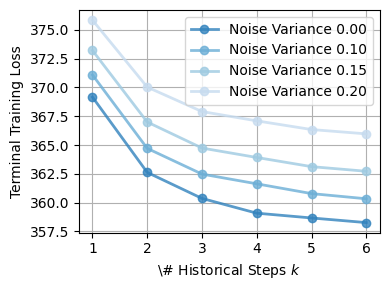

C:\Users\Administrator\AppData\Local\Temp\ipykernel_11924\4198494261.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab20c')


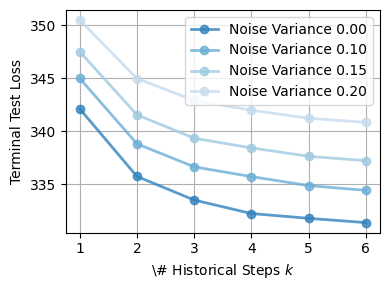

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.cm as cm
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Define the start and end of the subrange (between 0 and 1)
start = 0.0
end = 0.2

# Get the colormap
original_cmap = cm.get_cmap('tab20c')

# Create a new colormap from the subrange of the original colormap
subrange_cmap = LinearSegmentedColormap.from_list(
    'subrange_tab20c', original_cmap(np.linspace(start, end, 256))
)

# List of files for training and test loss data
train_loss_files = [
    r'YourDataPath/Noise_0.0TrainLossWrtPp_6_TrainMode_trainAtrainB_epochs_100_m_x_10_m_z_81_m_o_1_n_layers_20_tau_0.1_batch_size_4096_lr_0.001_seed_1.csv',
    r'YourDataPath/Noise_0.1TrainLossWrtPp_6_TrainMode_trainAtrainB_epochs_100_m_x_10_m_z_81_m_o_1_n_layers_20_tau_0.1_batch_size_4096_lr_0.001_seed_1.csv',
    r'YourDataPath/Noise_0.15TrainLossWrtPp_6_TrainMode_trainAtrainB_epochs_100_m_x_10_m_z_81_m_o_1_n_layers_20_tau_0.1_batch_size_4096_lr_0.001_seed_1.csv',        
    r'YourDataPath/Noise_0.2TrainLossWrtPp_6_TrainMode_trainAtrainB_epochs_100_m_x_10_m_z_81_m_o_1_n_layers_20_tau_0.1_batch_size_4096_lr_0.001_seed_1.csv',
]

test_loss_files = [
    r'YourDataPath/Noise_0.0TestLossWrtPp_6_TrainMode_trainAtrainB_epochs_100_m_x_10_m_z_81_m_o_1_n_layers_20_tau_0.1_batch_size_4096_lr_0.001_seed_1.csv',
    r'YourDataPath/Noise_0.1TestLossWrtPp_6_TrainMode_trainAtrainB_epochs_100_m_x_10_m_z_81_m_o_1_n_layers_20_tau_0.1_batch_size_4096_lr_0.001_seed_1.csv',
    r'YourDataPath/Noise_0.15TestLossWrtPp_6_TrainMode_trainAtrainB_epochs_100_m_x_10_m_z_81_m_o_1_n_layers_20_tau_0.1_batch_size_4096_lr_0.001_seed_1.csv',        
    r'YourDataPath/Noise_0.2TestLossWrtPp_6_TrainMode_trainAtrainB_epochs_100_m_x_10_m_z_81_m_o_1_n_layers_20_tau_0.1_batch_size_4096_lr_0.001_seed_1.csv',
]

# Load the data from CSV files into DataFrames
train_loss_data = [pd.read_csv(file) for file in train_loss_files]
test_loss_data = [pd.read_csv(file) for file in test_loss_files]

# Preview the first DataFrame to understand the structure of the data
train_loss_data[0].head()

# Function to plot the losses
def plot_losses(loss_data, title, ylabel, filename):
    plt.figure(figsize=(4, 3))
    colormap = cm.get_cmap('tab20c')
    
    # Plot for each p value
    for i, data in enumerate(loss_data):
        color = subrange_cmap(i / len(loss_data))
        # Extract the terminal loss (last row) for each p
        terminal_losses = data.iloc[-1]
        # Extract the noise coefficient from the filename for labeling
        noise_coef = os.path.basename(train_loss_files[i]).split("Noise_")[1].split("TrainLoss")[0]
        # Plotting
        plt.plot(terminal_losses.index.astype(int), terminal_losses.values, label=f"Noise Variance {float(noise_coef):.2f}", marker='o', color=color,linewidth=2,alpha=0.8)
    
    plt.xlabel(r'\# Historical Steps $k$')
    plt.ylabel(ylabel)
    # plt.title(title)
    plt.legend()
    plt.grid(True)
    # plt.ylim(355,390)
    plt.tight_layout()
    # plt.savefig(f'/mnt/data/{filename}.pdf')
    # return f'/mnt/data/{filename}.pdf'
    plt.savefig('./Noise_All'+'Final'+ylabel+'.pdf', bbox_inches='tight')
    plt.show()

# Plot Terminal Training Loss vs. Polynomial Order p
plot_train_loss = plot_losses(
    train_loss_data, 
    'Terminal Training Loss w.r.t. Polynomial Order p', 
    'Terminal Training Loss', 
    'terminal_train_loss_vs_p'
)

# Plot Terminal Test Loss vs. Polynomial Order p
plot_test_loss = plot_losses(
    test_loss_data, 
    'Terminal Test Loss w.r.t. Polynomial Order p', 
    'Terminal Test Loss', 
    'terminal_test_loss_vs_p'
)
